In [1]:
from functools import partial
from os.path import isfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F
import umap
import h5py


from astropt.local_datasets import GalaxyImageDataset
from astropt.model_utils import load_astropt


/global/homes/a/ashodkh/.conda/envs/my_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
telescope = "hsc"
device = 'cuda'

# set up HF galaxies in test set to be processed
def normalise(x):
    std, mean = torch.std_mean(x, dim=1, keepdim=True)
    x = (x - mean) / (std + 1e-8)      
    return x

def data_transforms():
    transform = transforms.Compose(
        [
            transforms.Lambda(normalise),
        ]
    )
    return transform

def _process_galaxy_wrapper(idx, func):
    """This function ensures that the image is tokenised in the same way as
    the pre-trained model is expecting"""
    galaxy = torch.from_numpy(np.array(idx[f"{telescope}_images"]).swapaxes(0, 2)).to(float)
    galaxy = F.interpolate(galaxy[None,:,:,:], size=(256, 256), mode='bilinear', align_corners=False).squeeze() 
    galaxy = func(galaxy).to(torch.float).to(device)
    galaxy_positions = torch.arange(0, len(galaxy), dtype=torch.long)
    if telescope == "hsc":
        mag_name = 'mag_model_hsc-g'
    elif telescope == 'jwst':
        mag_name = 'mag_model_hsc-g'
    mag_g = idx[mag_name]
    return {
        "images": galaxy.to(device),
        "images_positions": galaxy_positions.to(device),
        mag_name: mag_g,
    }

In [3]:
model_name = "astroPT"
model_size = "850M"
model = load_astropt("Smith42/astroPT_v2.0", path=f"astropt/{model_size}").to(device)
galproc = GalaxyImageDataset(
    None,
    spiral=True,
    transform={"images": data_transforms()},
    modality_registry=model.modality_registry,
)

Model type: native
Total parameters: 853.61M
Trainable parameters: 853.61M
Error(s) in loading state_dict for GPT:
	Missing key(s) in state_dict: "encoders.images.c_fc.weight", "encoders.images.c_proj.weight", "decoders.images.c_fc.weight", "decoders.images.c_proj.weight", "embedders.images.wpe.weight". 
	Unexpected key(s) in state_dict: "lm_head.images.c_fc.weight", "lm_head.images.c_proj.weight", "transformer.wte.images.c_fc.weight", "transformer.wte.images.c_proj.weight", "transformer.wpe.images.wpe.weight". 
Assuming we are loading a version of AstroPT < 3.0, so altering state dict key names to fit...
model loaded successfully from Smith42/astroPT_v2.0/astropt/850M
args: {'n_layer': 16, 'n_head': 8, 'n_embd': 2048, 'n_chan': 3, 'block_size': 1024, 'dropout': 0.0, 'modalities': [ModalityConfig(name='images', input_size=768, pos_input_size=1, patch_size=16, embed_pos=True, vocab_size=0, loss_weight=1.0)], 'attn_type': 'causal'}


In [4]:
n = 5000
batch_size = 100
ds = (
        load_dataset("Ashodkh/cosmosweb-hsc-jwst-high-snr-pil", split="train", streaming=True)
        .select_columns(("hsc_images", 'mag_model_hsc-g', 'mag_model_hsc-r', 'mag_model_hsc-z', 'lephare_photozs', 'lp_mass', 'lp_ssfr'))
        .filter(lambda idx: idx['mag_model_hsc-g'] is not None)
        .map(partial(_process_galaxy_wrapper, func=galproc.process_galaxy))
        .with_format("torch")
        .take(
            n + batch_size
        )  # use the first 100 examples of our dataset to shorten total inference time
    )
dl = iter(
    DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )
)

In [5]:
for data in dl:
    test_data = data
    break

/global/homes/a/ashodkh/.conda/envs/my_torch/lib/python3.12/site-packages/datasets/formatting/torch_formatter.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [6]:
test_data.keys()

dict_keys(['hsc_images', 'mag_model_hsc-g', 'mag_model_hsc-r', 'mag_model_hsc-z', 'lephare_photozs', 'lp_mass', 'lp_ssfr', 'images', 'images_positions'])

In [7]:
embeddings = []
feature_names = ['mag_model_hsc-g', 'mag_model_hsc-r', 'mag_model_hsc-z', 'lephare_photozs', 'lp_mass', 'lp_ssfr']
features = {}
for feature in feature_names:
    features[feature] = []
    
for data in tqdm(dl):
    #print(data['hsc_images'].shape)
    embeddings.append(model.generate_embeddings(data)["images"].detach().cpu().numpy())
    for feature in feature_names:
        features[feature].append(data[feature].detach().cpu().numpy())


0it [00:00, ?it/s]

torch.Size([100, 256, 768])


1it [00:09,  9.04s/it]

torch.Size([100, 256, 768])


2it [00:16,  8.10s/it]

torch.Size([100, 256, 768])


3it [00:22,  7.27s/it]

torch.Size([100, 256, 768])


4it [00:29,  7.05s/it]

torch.Size([100, 256, 768])


5it [00:37,  7.29s/it]

torch.Size([100, 256, 768])


6it [00:43,  7.08s/it]

torch.Size([100, 256, 768])


7it [00:50,  6.86s/it]

torch.Size([100, 256, 768])


8it [00:57,  6.85s/it]

torch.Size([100, 256, 768])


9it [01:04,  7.11s/it]

torch.Size([100, 256, 768])


10it [01:11,  6.89s/it]

torch.Size([100, 256, 768])


11it [01:17,  6.66s/it]

torch.Size([100, 256, 768])


12it [01:24,  6.93s/it]

torch.Size([100, 256, 768])


13it [01:31,  6.78s/it]

torch.Size([100, 256, 768])


14it [01:37,  6.64s/it]

torch.Size([100, 256, 768])


15it [01:44,  6.80s/it]

torch.Size([100, 256, 768])


16it [01:52,  7.05s/it]

torch.Size([100, 256, 768])


17it [01:58,  6.89s/it]

torch.Size([100, 256, 768])


18it [02:05,  6.73s/it]

torch.Size([100, 256, 768])


19it [02:13,  7.09s/it]

torch.Size([100, 256, 768])


20it [02:19,  6.90s/it]

torch.Size([100, 256, 768])


21it [02:26,  6.75s/it]

torch.Size([100, 256, 768])


22it [02:33,  6.84s/it]

torch.Size([100, 256, 768])


23it [02:40,  7.06s/it]

torch.Size([100, 256, 768])


24it [02:47,  7.00s/it]

torch.Size([100, 256, 768])


25it [02:54,  6.94s/it]

torch.Size([100, 256, 768])


26it [03:03,  7.67s/it]

torch.Size([100, 256, 768])


27it [03:13,  8.21s/it]

torch.Size([100, 256, 768])


28it [03:23,  8.70s/it]

torch.Size([100, 256, 768])


29it [03:32,  8.88s/it]

torch.Size([100, 256, 768])


30it [03:39,  8.36s/it]

torch.Size([100, 256, 768])


31it [03:49,  8.93s/it]

torch.Size([100, 256, 768])


32it [03:58,  8.99s/it]

torch.Size([100, 256, 768])


33it [04:08,  9.27s/it]

torch.Size([100, 256, 768])


34it [04:18,  9.46s/it]

torch.Size([100, 256, 768])


35it [04:26,  9.04s/it]

torch.Size([100, 256, 768])


36it [04:33,  8.35s/it]

torch.Size([100, 256, 768])


37it [04:42,  8.60s/it]

torch.Size([100, 256, 768])


38it [04:49,  7.98s/it]

torch.Size([100, 256, 768])


39it [04:57,  8.04s/it]

torch.Size([100, 256, 768])


40it [05:06,  8.31s/it]

torch.Size([100, 256, 768])


41it [05:13,  7.94s/it]

torch.Size([100, 256, 768])


42it [05:21,  8.10s/it]

torch.Size([100, 256, 768])


43it [05:30,  8.20s/it]

torch.Size([100, 256, 768])


44it [05:37,  7.88s/it]

torch.Size([100, 256, 768])


45it [05:46,  8.08s/it]

torch.Size([100, 256, 768])


46it [05:52,  7.54s/it]

torch.Size([100, 256, 768])


47it [06:00,  7.62s/it]

torch.Size([100, 256, 768])


48it [06:07,  7.45s/it]

torch.Size([100, 256, 768])


49it [06:13,  7.25s/it]

torch.Size([100, 256, 768])


50it [06:20,  7.61s/it]


In [8]:
embeddings = np.vstack(embeddings)
for feature in feature_names:
    features[feature] = np.concatenate(features[feature]) 
    

In [9]:
embeddings.shape

(5000, 2048)

In [10]:
import pickle


dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'
np.save(dir_out + f'embeddings_{telescope}_{n}_{model_name}_{model_size}_upsampled_images', embeddings)
with open(dir_out + f'features_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.pkl', 'wb') as f_pickle:
    pickle.dump(features, f_pickle)

In [11]:
reducer = umap.UMAP(n_components=2)
umap_embeddings = reducer.fit_transform(embeddings)


In [12]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())

['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

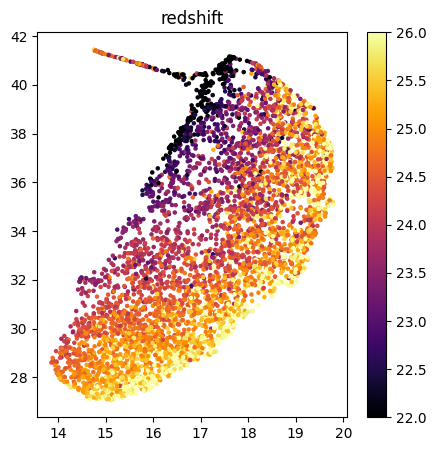

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

#sd = ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=f['mag_model_hsc-g'][:embeddings.shape[0]], s=5, vmin=22, vmax=26, cmap='inferno');
sd = ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=features['mag_model_hsc-g'], s=5, vmin=22, vmax=26, cmap='inferno');

#ax.set_title('redshift')
fig.colorbar(sd, ax=ax)


In [14]:
f['hsc_images'].shape

(56322, 5, 39, 39)